In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import os
import re
import string
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahrul59","key":"a2a0b57736f84e06bf56dc1d47197e48"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 143MB/s]


In [5]:
!unzip twitter-entity-sentiment-analysis.zip

Archive:  twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [6]:
df = pd.read_csv('/content/twitter_training.csv', nrows = 3000)
df.head(5)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df.rename(columns={'Positive': 'sentiment',
                   'im getting on borderlands and i will murder you all ,': 'tweet_content'},inplace=True)

In [8]:
df_sentiment = df.drop(columns=['2401', 'Borderlands'])
df_sentiment.head(5)

,sentiment,tweet_content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


<Axes: >

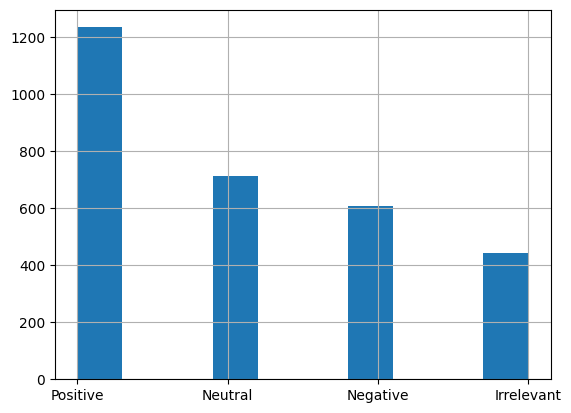

In [9]:
df_sentiment["sentiment"].hist()

In [10]:
df_sentiment["tweet_content"] = df_sentiment["tweet_content"].astype(str)
df_sentiment["sentiment"] = df_sentiment["sentiment"].astype(str)

In [11]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      3000 non-null   object
 1   tweet_content  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [12]:
df_sentiment.isnull().sum()

sentiment        0
tweet_content    0
dtype: int64

In [13]:
df_sentiment.columns

Index(['sentiment', 'tweet_content'], dtype='object')

In [14]:
df_sentiment.shape

(3000, 2)

In [15]:
df_sentiment.sentiment.value_counts()

Positive      1235
Neutral        714
Negative       607
Irrelevant     444
Name: sentiment, dtype: int64

In [16]:
df_sentiment.tweet_content = df_sentiment.tweet_content.apply(lambda x: x.lower())

def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_sentiment.tweet_content = df_sentiment.tweet_content.apply(lambda x: cleaner(x))

lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df_sentiment.tweet_content = df_sentiment.tweet_content.apply(lambda x: lem(x))

def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_sentiment['tweet_content'].apply(rem_numbers)

st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_sentiment.tweet_content = df_sentiment.tweet_content.apply(lambda x: stopword(x))

In [17]:
df_sentiment.head(5)

,sentiment,tweet_content
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [18]:
sentiment = pd.get_dummies(df_sentiment.sentiment)
df_sentiment_new = pd.concat([df_sentiment, sentiment], axis=1)
df_sentiment_new = df_sentiment_new.drop(columns='sentiment')
df_sentiment_new.head(5)

,tweet_content,Irrelevant,Negative,Neutral,Positive
0,i am coming to the borders and i will kill you...,0,0,0,1
1,im getting on borderlands and i will kill you ...,0,0,0,1
2,im coming on borderlands and i will murder you...,0,0,0,1
3,im getting on borderlands 2 and i will murder ...,0,0,0,1
4,im getting into borderlands and i can murder y...,0,0,0,1


In [19]:
tweet = df_sentiment_new['tweet_content'].values
labels = df_sentiment_new[['Irrelevant', 'Negative', 'Neutral', 'Positive']].values

In [20]:
labels

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0]], dtype=uint8)

In [21]:
tweet_train, tweet_test, labels_train, labels_test = train_test_split(tweet, labels, test_size=0.2, shuffle=True)

In [22]:
print("tweet_train:", len(tweet_train))
print("tweet_test:", len(tweet_test))
print("labels_train:", len(labels_train))
print("labels_test:", len(labels_test))

tweet_train: 2400
tweet_test: 600
labels_train: 2400
labels_test: 600


In [23]:
vocab_size = 5000
oov_tok = 'x'
symbols = '!"#$%&()*+,-./:;<=>@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words = vocab_size,
                      oov_token = oov_tok,
                      filters = symbols)

tokenizer.fit_on_texts(tweet_train)

sekuens_train = tokenizer.texts_to_sequences(tweet_train)
sekuens_test = tokenizer.texts_to_sequences(tweet_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy',)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 435844 (1.66 MB)
Trainable params: 435844 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


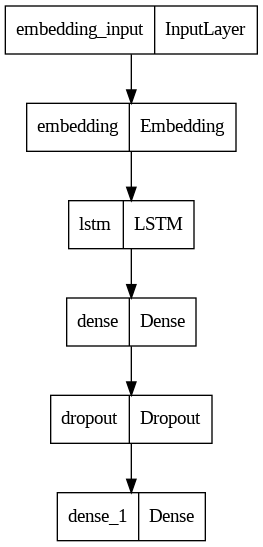

In [25]:
plot_model(model)

In [26]:
accuracy_threshold = 0.9
class stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > accuracy_threshold and logs.get('val_accuracy') > accuracy_threshold:
      print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
      self.model.stop_training=True
callbacks=stop()

checkpoint_path = "model.h5"
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True
                             )

In [27]:
num_epoch = 200
history = model.fit(padded_train,
                    labels_train,
                    epochs=num_epoch,
                    validation_data=(padded_test, labels_test),
                    verbose=2,
                    callbacks=[callbacks, checkpoint],
                    validation_steps=30)

Epoch 1/200
75/75 - 26s - loss: 1.2726 - accuracy: 0.4054 - val_loss: 1.0560 - val_accuracy: 0.5733 - 26s/epoch - 348ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 6s - loss: 0.8852 - accuracy: 0.6650 - val_loss: 0.6221 - val_accuracy: 0.8083 - 6s/epoch - 77ms/step
Epoch 3/200
75/75 - 4s - loss: 0.3057 - accuracy: 0.8979 - val_loss: 0.3792 - val_accuracy: 0.8583 - 4s/epoch - 48ms/step
Epoch 4/200

For Epoch 3 
Accuracy has reach = 95.29% training has been stopped.
75/75 - 3s - loss: 0.1386 - accuracy: 0.9529 - val_loss: 0.2745 - val_accuracy: 0.9083 - 3s/epoch - 43ms/step


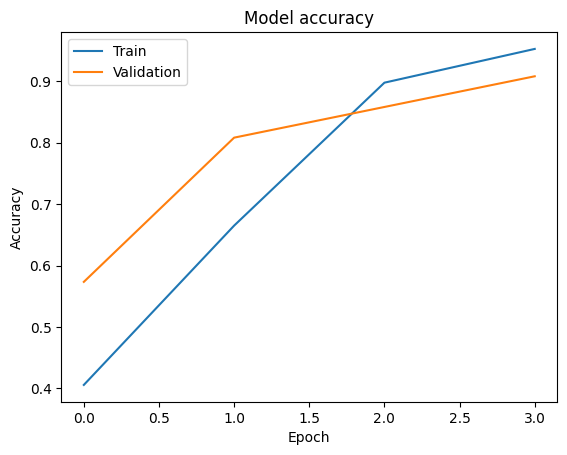

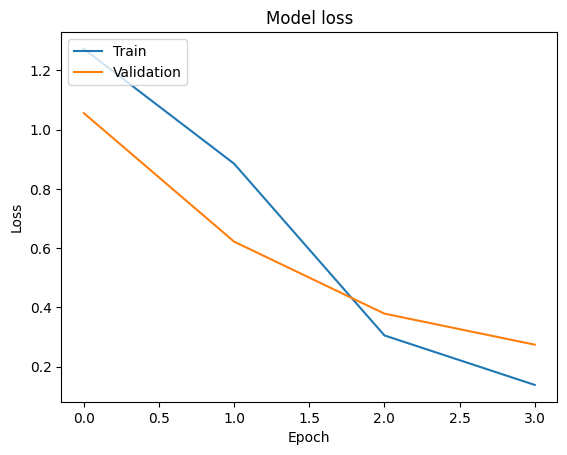

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()